# Project: Bank customers outflow

## Importing the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix,\
precision_recall_curve, accuracy_score

import warnings
warnings.simplefilter('ignore')

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sweetviz as sv

In [2]:
data = pd.read_csv(r'C:\Users\exeve\Downloads\Churn.csv')


## Data analysis

In [3]:
analyze_report = sv.analyze(data)

                                             |                                             | [  0%]   00:00 ->…

In [4]:
analyze_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7796,7797,15773949,Cherkasova,692,France,Female,36,3.0,0.00,2,1,1,8282.22,0
8650,8651,15731865,Unwin,637,France,Male,27,1.0,0.00,2,1,0,91291.20,0
7473,7474,15638272,Tien,609,Spain,Male,32,4.0,99883.16,1,1,1,120594.85,0
5420,5421,15583462,Graham,695,France,Male,28,NaN,171069.39,2,1,1,88689.40,0
6388,6389,15582033,Manfrin,753,Germany,Male,44,3.0,138076.47,1,1,0,15523.09,1


We will convert columns with an integer (int) or decimal (float) type that represent “Yes” or “No” to a Boolean type (bool).

### Duplicates

In [7]:
data.duplicated().sum()

0

In [8]:
display(data['Gender'].unique())
display(data['Geography'].unique())

array(['Female', 'Male'], dtype=object)

array(['France', 'Spain', 'Germany'], dtype=object)

Дубликатов нет.

### Gaps

In [9]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

There are 909 gaps in the 'Tenure' column. Let's see if there is any logical connection with other features.

In [10]:
data[data['Tenure'].isna()].sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1265,1266,15662291,Davidson,534,France,Female,55,NaN,116973.26,3,1,0,122066.50,1
1245,1246,15658052,Cameron,626,France,Female,44,NaN,81553.93,1,1,0,20063.63,1
9113,9114,15760662,Francis,521,Germany,Female,29,NaN,87212.80,1,1,1,994.86,0
1960,1961,15623647,Dellucci,655,Spain,Female,36,NaN,135515.76,1,1,0,86013.96,0
2977,2978,15655123,Dumetolisa,505,Spain,Female,45,NaN,131355.30,3,1,0,195395.33,1
6986,6987,15702377,Knorr,627,Spain,Male,48,NaN,132759.80,1,1,0,78899.22,0
3623,3624,15627162,Blesing,695,Germany,Male,27,NaN,125552.96,1,1,0,105291.26,0
473,474,15681705,Fanucci,785,France,Male,28,NaN,0.00,2,1,0,77231.27,0
6905,6906,15754012,Shepherdson,687,France,Female,35,NaN,110752.15,2,1,1,47921.22,0
1787,1788,15753549,Dubinina,669,France,Male,25,NaN,157848.53,1,0,0,37543.93,1


No connection visible. Perhaps this means that either these clients do not have real estate and, in fact, these can be replaced by zeros, or that the values ​​have not been entered. We can also create a separate model to predict NaN values. But first, let's see if this column is important for the model at all. In case it's not, we can simply remove the entire columns.

There are no values that can be considered extreme.

### Graph of distribution of the "Exited" target by parameters

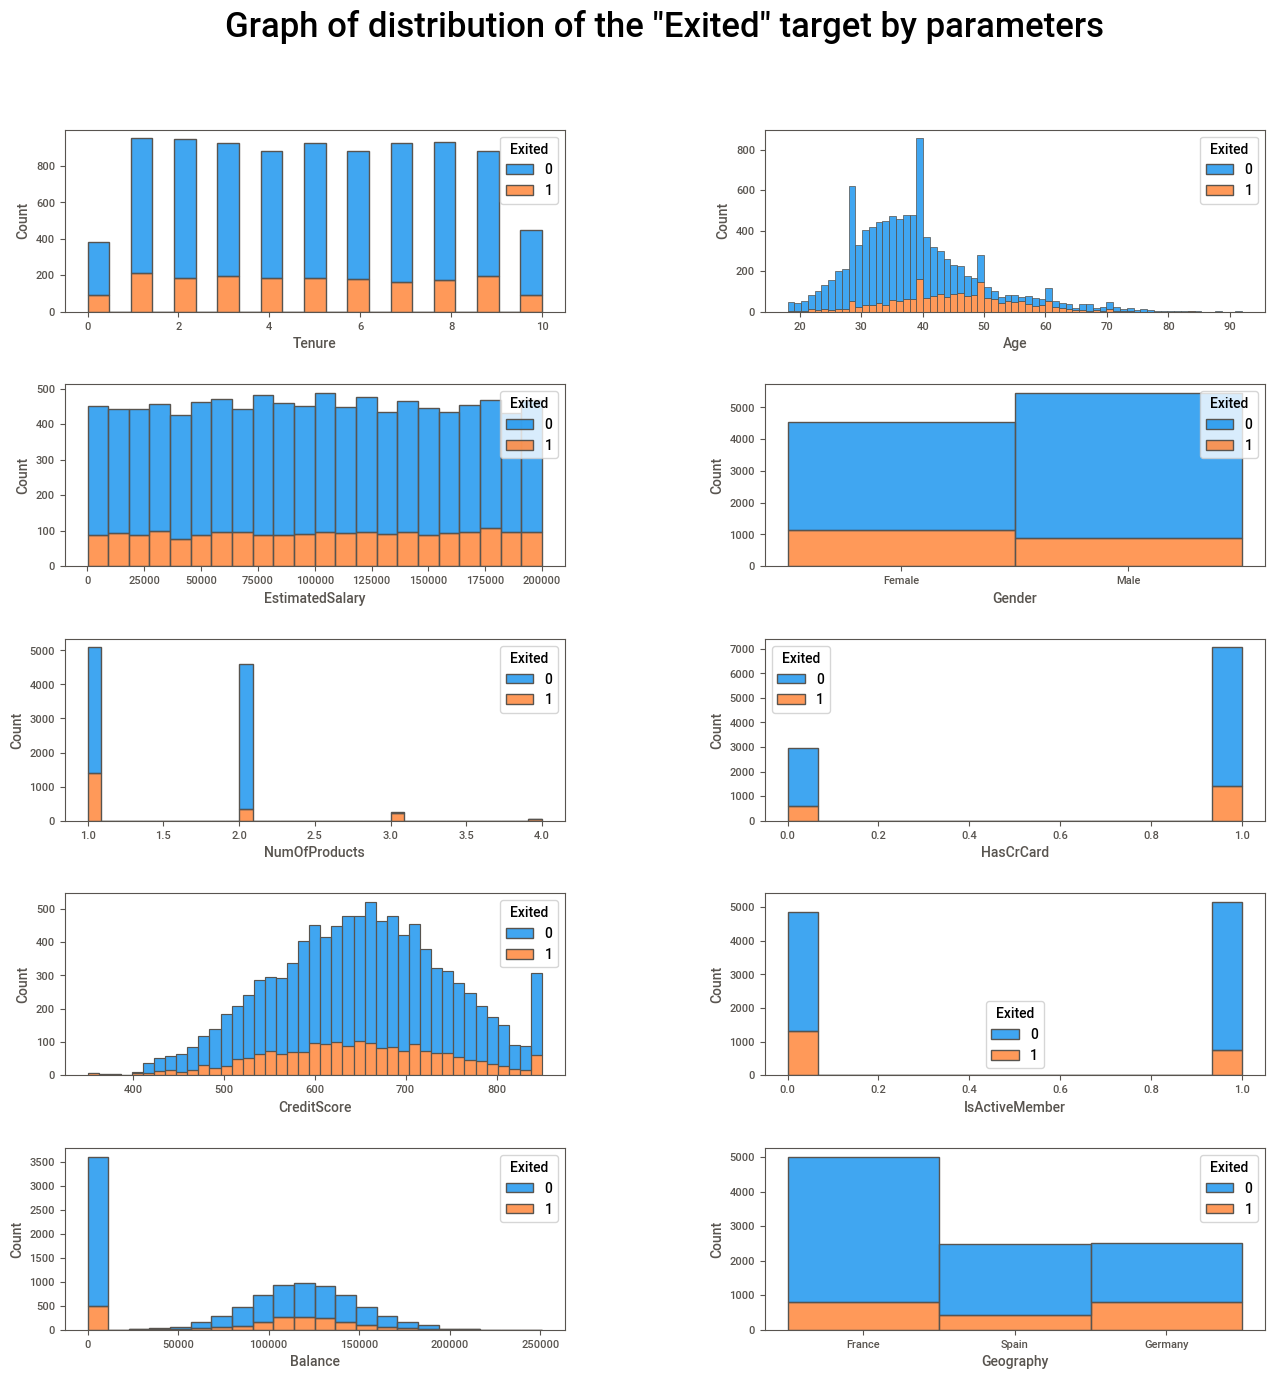

In [11]:
fig, ax = plt.subplots(5,2, figsize = (15,15))
fig.suptitle('Graph of distribution of the "Exited" target by parameters', size=25)
sns.histplot(ax=ax[0,0],data = data, x = 'Tenure', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[1,0], data = data, x = 'EstimatedSalary', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[1,1], data = data, x = 'Gender', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[0,1], data = data, x = 'Age', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[2,0], data = data, x = 'NumOfProducts', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[2,1], data = data, x = 'HasCrCard', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[3,1], data = data, x = 'IsActiveMember', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[3,0], data = data, x = 'CreditScore', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[4,1], data = data, x = 'Geography', hue = 'Exited', multiple = 'stack')
sns.histplot(ax=ax[4,0], data = data, x = 'Balance', hue = 'Exited', multiple = 'stack')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

### Correlation Heatmap 

<Axes: >

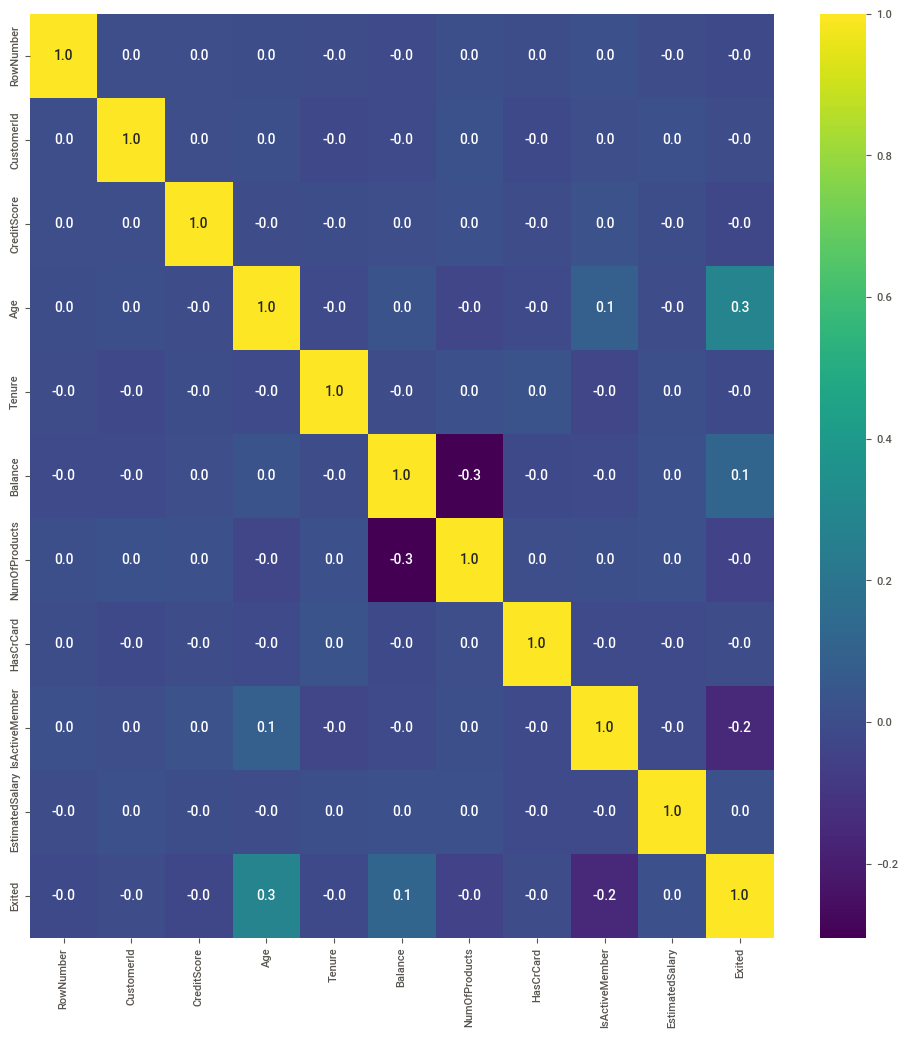

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), annot = True, fmt = '.1f', cmap = 'viridis')


No correlation.

### Removing unnecessary columns

We also remove columns that represent client identification data; I don’t think that whether a client leaves or not can depend on his name or client number.

In [13]:
data = data.drop(['EstimatedSalary', 'Tenure','RowNumber', 'CustomerId', 'Surname'], axis = 1)

### Creating dummy columns to represent categorical features

In [14]:
data = pd.get_dummies(data, drop_first = True)
data = data.rename(columns={'Geography_Spain':'Spain','Geography_France':'France', 'Geography_Germany':'Germany',\
                          'Gender_Female':'Female','Gender_Male':'Male'})

### Changing data types

In [15]:
data['Spain'] = data['Spain'].astype('bool')
data['Germany'] = data['Germany'].astype('bool')
data['Male'] = data['Male'].astype('bool')
data['HasCrCard'] = data['HasCrCard'].astype('bool')
data['IsActiveMember'] = data['IsActiveMember'].astype('bool')
data['Exited'] = data['Exited'].astype('bool')

## Examining the problem

- In this section, we will divide the total sample into three samples (training, validation, testing) in a ratio of 60:20:20. - - We will scale the numerical values so that the model does not think that higher values have more weight in relation to the target. 
- We will create a dummy model, from which we will deduce what accuracy the model must have in order to be considered adequate.
- We will look at the overall class imbalance. We will then build three models (Decision Tree, Random Forest, Logistic Regression) and select the best hyperparameters for each. 
- We will see the imbalance of each model through the recall, precision and confusion matrix.

### Division into train, valid and test samples

In [16]:
pd.options.mode.chained_assignment = None

target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

### Scaling

In [17]:
numeric = ['Age', 'Balance', 'CreditScore', 'NumOfProducts']


scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.sample(10)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Germany,Spain,Male
8766,-0.035196,-0.278288,0.161169,-0.891560,False,False,False,True,False
798,0.317888,-0.373192,1.785978,0.830152,True,True,False,False,False
4853,0.328273,0.196229,0.943544,0.830152,True,True,False,False,False
3818,0.754050,0.480939,-1.233163,-0.891560,False,True,False,False,False
192,-1.800614,0.101325,-1.233163,0.830152,False,False,False,False,True
3043,-0.170198,-0.088482,-1.233163,-0.891560,True,False,False,False,False
7023,-1.333298,-0.942612,1.089788,0.830152,True,False,True,False,True
2278,-1.862923,-0.562998,0.792590,-0.891560,False,True,False,False,False
54,-0.533667,0.291132,0.352564,-0.891560,True,False,True,False,True
2198,-1.862923,0.860552,-1.233163,0.830152,True,False,False,True,True


### General imbalance

Checking the imbalance:

In [18]:
target.value_counts()

False    7963
True     2037
Name: Exited, dtype: int64

There is a large class imbalance, approximately 4:1 ([0,1]).

### DummyClassifier() model

In [19]:
%%time
        
from sklearn.dummy import DummyClassifier

model_dummy = DummyClassifier(strategy = 'constant', constant = 1, random_state = 12345)
model_dummy.fit(features_train, target_train) 
predicted_dummy = model_dummy.predict(features_valid)
dummy_f1_score = f1_score(target_valid, predicted_dummy)
   
print('Dummy Model Confusion Matrix:\n\n', confusion_matrix(target_valid, predicted_dummy)) 
print('')
print('Recall:', recall_score(target_valid, predicted_dummy))
print('Precision:', precision_score(target_valid, predicted_dummy))
print('Dummy model f1_score:', dummy_f1_score)
print('')


Dummy Model Confusion Matrix:

 [[   0 1582]
 [   0  418]]

Recall: 1.0
Precision: 0.209
Dummy model f1_score: 0.3457402812241522

CPU times: total: 0 ns
Wall time: 20.7 ms


This dummy model always predicts 1, so it is normal that there are no TN and FN in the matrix. Thus, for our model to be adequate, it must exceed the f1_score of 0.3457 of this random model.

### unbalanced DecisionTreeClassifier() model

In [20]:
%%time

best_unbalanced_tree_f1_score = 0
best_unbalanced_tree_depth = 0

for depth in range(1, 6):        
    
    model_unbalanced_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_unbalanced_tree.fit(features_train, target_train) 
    predicted_unbalanced_tree = model_unbalanced_tree.predict(features_valid)
    unbalanced_tree_f1_score = f1_score(target_valid, predicted_unbalanced_tree)
    if unbalanced_tree_f1_score > best_unbalanced_tree_f1_score:
        best_unbalanced_tree_f1_score = unbalanced_tree_f1_score
        best_unbalanced_tree_depth = depth
        
print('Confusion Matrix:\n\n', confusion_matrix(target_valid, predicted_unbalanced_tree)) 
print('')
print('Recall:', recall_score(target_valid, predicted_unbalanced_tree))
print('Precision:', precision_score(target_valid, predicted_unbalanced_tree))
print('')
print('The best unbalanced DecisionTreeClassifier model has a max_depth of',best_unbalanced_tree_depth,\
      'with an f1_score of',best_unbalanced_tree_f1_score)
print('')



Confusion Matrix:

 [[1532   50]
 [ 249  169]]

Recall: 0.4043062200956938
Precision: 0.771689497716895

The best unbalanced DecisionTreeClassifier model has a max_depth of 4 with an f1_score of 0.5454545454545454

CPU times: total: 62.5 ms
Wall time: 109 ms


- A low recall value indicates that there is too much FN.
- This was already visible in the matrix: 169 TP and 249 FN (recall = 169 TP / 169 TP + 249 FN)
- In the best combination of Recall and Precision, f1_score = 0.5454.

### unbalanced RandomForestClassifier() model

In [21]:
%%time

best_result = 0
best_depth_RFC = 0
    
best_est = 0
for est in range(10, 101, 10):
    for depth in range (1, 11):
        
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predicted_forest = model.predict(features_valid)
        result = f1_score(target_valid, predicted_forest)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth_RFC = depth
            
print('Confusion Matrix:\n\n', confusion_matrix(target_valid, predicted_forest))
print('')
print('Recall:', recall_score(target_valid, predicted_forest))
print('Precision:', precision_score(target_valid, predicted_forest))
print('')
print('The best unbalanced RandomForestClassifier model has a max_depth of',best_depth_RFC,',',best_est,\
      'n_estimators, with an f1_score of',best_result)
print('')

Confusion Matrix:

 [[1533   49]
 [ 232  186]]

Recall: 0.4449760765550239
Precision: 0.7914893617021277

The best unbalanced RandomForestClassifier model has a max_depth of 10 , 10 n_estimators, with an f1_score of 0.5857988165680473

CPU times: total: 26.6 s
Wall time: 29.4 s


It's a little better here. f1_score is already 0.5857

### unbalanced LogisticRegression() model

In [22]:
%%time


model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predicted_logic = model.predict(features_valid)
result = f1_score(target_valid, predicted_logic )

    
print('Confusion Matrix:\n\n',confusion_matrix(target_valid, predicted_logic))
print('')  
print('Recall:', recall_score(target_valid, predicted_logic))
print('Precision:', precision_score(target_valid, predicted_logic))
print('')
print('The best unbalanced LogisticRegression model has a f1_score of',result)
print('')


Confusion Matrix:

 [[1510   72]
 [ 322   96]]

Recall: 0.22966507177033493
Precision: 0.5714285714285714

The best unbalanced LogisticRegression model has a f1_score of 0.3276450511945393

CPU times: total: 15.6 ms
Wall time: 59.1 ms


And here is the worst model. Too many FPs and FNs.

It can be said that regardless of class imbalance, with better hyperparameters, the best model is **RandomForestClassifier(max_depth=10, n_estimators=10, random_state=12345) with f1_score 0.5857**. The worst model in this case is **LogisticRegression(max_iter = 1000, solver = 'lbfgs', random_state = 12345) with f1_score 0.3276**

Let's graphically compare the TPR indicators with the FPR indicators, and also display the area under the curve of each model.

AUC-ROC DecisionTreeClassifier 0.8129963887998354
AUC-ROC RandomForestClassifier 0.8380033450480586
AUC-ROC LogisticRegression 0.7577819246426606
AUC-ROC DummyClassifier 0.5


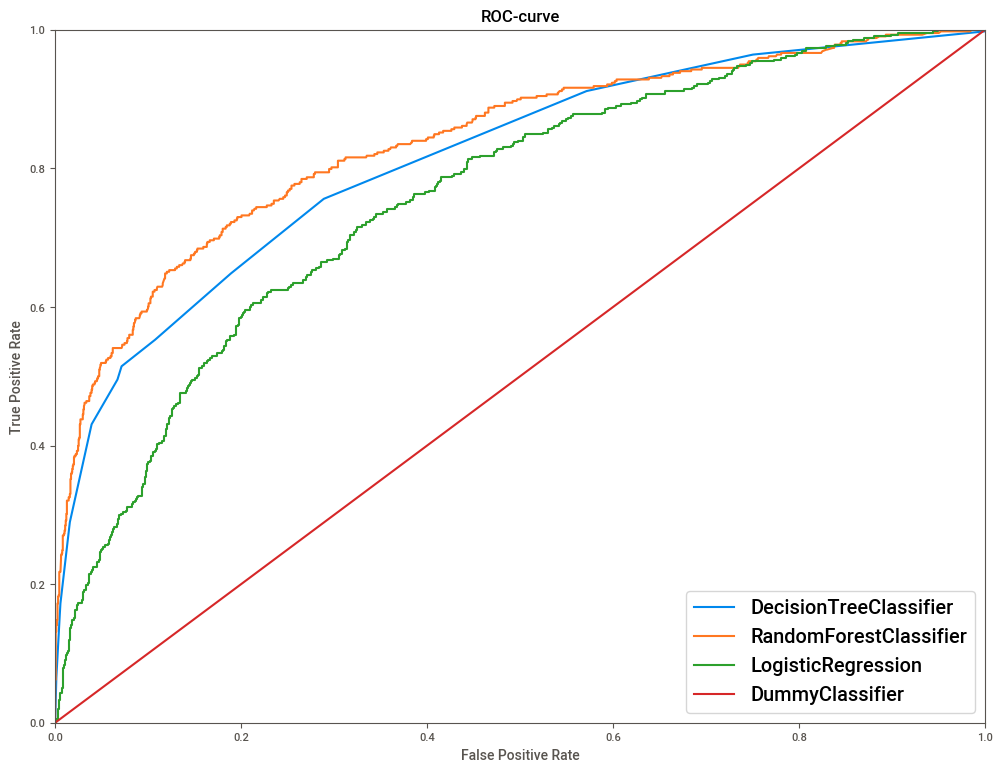

In [23]:
plt.figure(figsize=[12,9])


model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth = 10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(solver='sag', max_iter = 1000, random_state = 12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = DummyClassifier(strategy = 'constant', constant = 1, random_state = 12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DummyClassifier',auc_roc)
plt.plot(fpr, tpr, label='DummyClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-curve")
plt.show()

As we said earlier, RandomeForestClassifier() is the best model. The area under the curve is 23% larger than the Dummy model, as shown in the graph.

## Fighting Imbalance

To fight the imbalance, let’s compare the models:

- With class weighting
- With an increase in the sample of ones
- With a decrease in the sample of zeros
- With changing the threshold for LogisticRegression()

### Class weighting

By default, the weight of each class is 0.5. In the parameters we will specify class_weight = 'balanced' so that the class weights are distributed according to the frequency of their occurrence.

#### Weighting RandomForestClassifier()

In [24]:
%%time

model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 10, max_depth = 10, random_state = 12345)
model.fit(features_train, target_train)
prediction = model.predict(features_valid)

print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('')

Recall: 0.6411483253588517 Precision: 0.589010989010989 F1: 0.6139747995418098

Confusion Matrix:

 [[1395  187]
 [ 150  268]]

CPU times: total: 109 ms
Wall time: 110 ms


#### Weighting LogisticRegression()

In [25]:
%%time

model = LogisticRegression(random_state=12345, solver='sag', max_iter=1000, class_weight = 'balanced')
model.fit(features_train, target_train)
prediction= model.predict(features_valid)
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('')

Recall: 0.6794258373205742 Precision: 0.37917222963951935 F1: 0.48671808054841476

Confusion Matrix:

 [[1117  465]
 [ 134  284]]

CPU times: total: 62.5 ms
Wall time: 57.8 ms


#### Weighting DecisionTreeClassifier()

In [26]:
%%time

model = DecisionTreeClassifier(class_weight = 'balanced',random_state=12345, max_depth=4)
model.fit(features_train, target_train) 
predicted = model.predict(features_valid)
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('')

Recall: 0.6794258373205742 Precision: 0.37917222963951935 F1: 0.48671808054841476

Confusion Matrix:

 [[1117  465]
 [ 134  284]]

CPU times: total: 31.2 ms
Wall time: 38.3 ms


AUC-ROC DecisionTreeClassifier 0.8140678022489852
AUC-ROC RandomForestClassifier 0.8476211143304763
AUC-ROC LogisticRegression 0.7624955389277699
AUC-ROC DummyClassifier 0.5


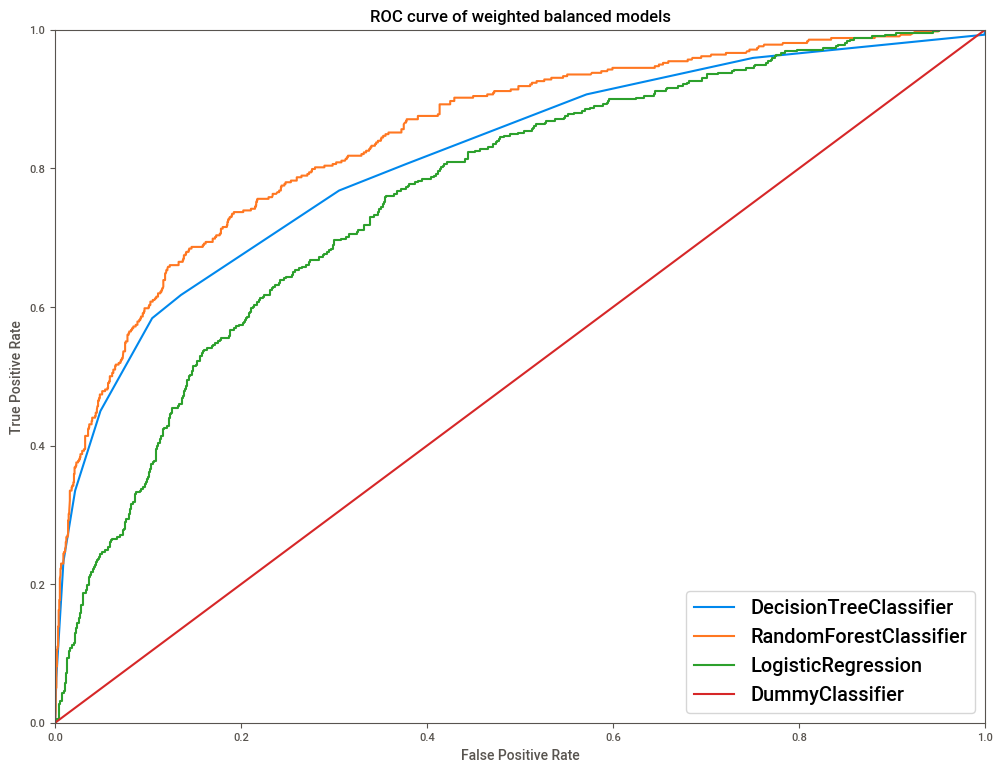

In [27]:
plt.figure(figsize=[12,9])


model = DecisionTreeClassifier(class_weight = 'balanced', random_state=12345, max_depth=4)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(class_weight = 'balanced', random_state=12345, n_estimators=10, max_depth = 10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(class_weight = 'balanced', solver='sag', max_iter = 1000, random_state = 12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = DummyClassifier(strategy = 'constant', constant = 1, random_state = 12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DummyClassifier',auc_roc)
plt.plot(fpr, tpr, label='DummyClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC curve of weighted balanced models")
plt.show()

When weighing classes, the best model is RandomForestClassifier(class_weight = 'balanced', n_estimators = 10, max_depth = 10, random_state = 12345) with f1_score 0.61 and AUC-ROC score 0.84.

### Increasing the sample


#### upsample() function

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#### Upsampling on RandomForestClassifier() model

In [29]:
%%time

model = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 12345)
model.fit(features_upsampled, target_upsampled)
prediction = model.predict(features_valid)


print('Balance:\n\n', target_upsampled.value_counts())
print('')
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('')

Balance:

 False    4804
True     4784
Name: Exited, dtype: int64

Recall: 0.6961722488038278 Precision: 0.5233812949640287 F1: 0.5975359342915811

Confusion Matrix:

 [[1317  265]
 [ 127  291]]

CPU times: total: 109 ms
Wall time: 137 ms


#### Upsampling on LogisticRegression() model

In [30]:
%%time

model = LogisticRegression(random_state=12345, solver='sag', max_iter=1000)
model.fit(features_upsampled, target_upsampled)
prediction = model.predict(features_valid)


        
print('Balance:\n\n', target_upsampled.value_counts())
print('')
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('') 


Balance:

 False    4804
True     4784
Name: Exited, dtype: int64

Recall: 0.6770334928229665 Precision: 0.37986577181208053 F1: 0.4866723989681858

Confusion Matrix:

 [[1120  462]
 [ 135  283]]

CPU times: total: 46.9 ms
Wall time: 62.9 ms


#### Upsampling on DecisionTreeClassifier() model

In [31]:
%%time

model = DecisionTreeClassifier(random_state=12345, max_depth = 4, class_weight = 'balanced')
model.fit(features_upsampled, target_upsampled)
prediction = model.predict(features_valid)

       
print('Balance:\n\n', target_upsampled.value_counts())
print('')
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('') 

Balance:

 False    4804
True     4784
Name: Exited, dtype: int64

Recall: 0.7727272727272727 Precision: 0.40074441687344914 F1: 0.5277777777777778

Confusion Matrix:

 [[1099  483]
 [  95  323]]

CPU times: total: 78.1 ms
Wall time: 46.3 ms


With the upsampling method, the best model is still RandomForestClassifier(), but its accuracy is lower than the previous balancing method: 0.59

AUC-ROC DecisionTreeClassifier 0.8186301937466353
AUC-ROC RandomForestClassifier 0.8430436005540803
AUC-ROC LogisticRegression 0.7624093419389181
AUC-ROC DummyClassifier 0.5


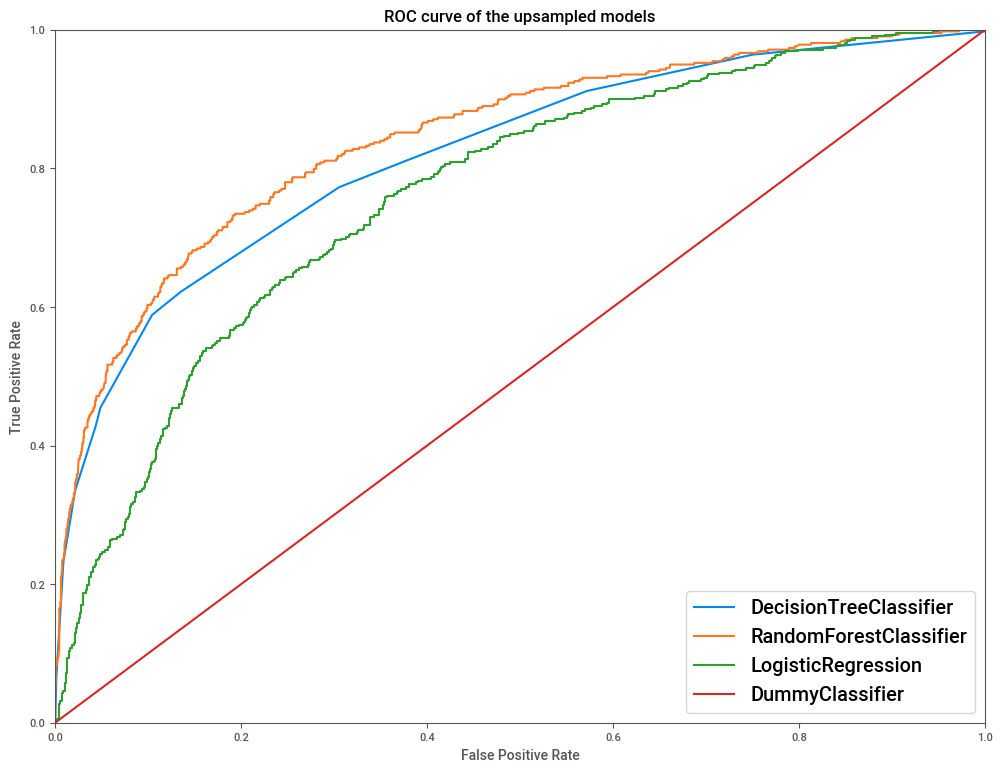

In [32]:
plt.figure(figsize=[12,9])


model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier( random_state=12345, n_estimators=10, max_depth = 10)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression( solver='sag', max_iter = 1000, random_state = 12345)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = DummyClassifier(strategy = 'constant', constant = 1, random_state = 12345)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DummyClassifier',auc_roc)
plt.plot(fpr, tpr, label='DummyClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC curve of the upsampled models")
plt.show()

### Decreasing the sample

#### downsample() function

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#### Downsampling on the RandomForestClassifier() model

In [34]:
%%time

model = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 12345)
model.fit(features_downsampled, target_downsampled)
prediction = model.predict(features_valid)

print('Balance:\n\n', target_downsampled.value_counts())
print('')
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('') 

Balance:

 False    1201
True     1196
Name: Exited, dtype: int64

Recall: 0.7272727272727273 Precision: 0.4470588235294118 F1: 0.5537340619307832

Confusion Matrix:

 [[1206  376]
 [ 114  304]]

CPU times: total: 31.2 ms
Wall time: 63 ms


#### Downsampling on the DecisionTreeClassifier() model

In [35]:
%%time

model = DecisionTreeClassifier(max_depth = 4, random_state = 12345)
model.fit(features_downsampled, target_downsampled)
prediction = model.predict(features_valid)

print('Balance:\n\n', target_downsampled.value_counts())
print('')
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('') 

Balance:

 False    1201
True     1196
Name: Exited, dtype: int64

Recall: 0.7703349282296651 Precision: 0.4107142857142857 F1: 0.5357737104825291

Confusion Matrix:

 [[1120  462]
 [  96  322]]

CPU times: total: 0 ns
Wall time: 15.7 ms


#### Downsampling on the LogisticRegression() model

In [36]:
%%time

model = LogisticRegression(max_iter = 1000, solver = 'sag', random_state = 12345)
model.fit(features_downsampled, target_downsampled)
prediction = model.predict(features_valid)

print('Balance:\n\n', target_downsampled.value_counts())
print('')
print('Recall:',recall_score(target_valid, prediction),\
      'Precision:',precision_score(target_valid, prediction),\
      'F1:',f1_score(target_valid, prediction))    
print('')
print('Confusion Matrix:\n\n',confusion_matrix(target_valid,prediction))
print('') 

Balance:

 False    1201
True     1196
Name: Exited, dtype: int64

Recall: 0.6842105263157895 Precision: 0.3828647925033467 F1: 0.4909871244635193

Confusion Matrix:

 [[1121  461]
 [ 132  286]]

CPU times: total: 62.5 ms
Wall time: 31.6 ms


With the downsampling method, the best model is still RandomForestClassifier(), but like DecisionTreeClassifier(), its accuracy has decreased compared to the previous balancing method: 0.55.

AUC-ROC DecisionTreeClassifier 0.8177236131358162
AUC-ROC RandomForestClassifier 0.8309692170893848
AUC-ROC LogisticRegression 0.7626165171577376
AUC-ROC DummyClassifier 0.5


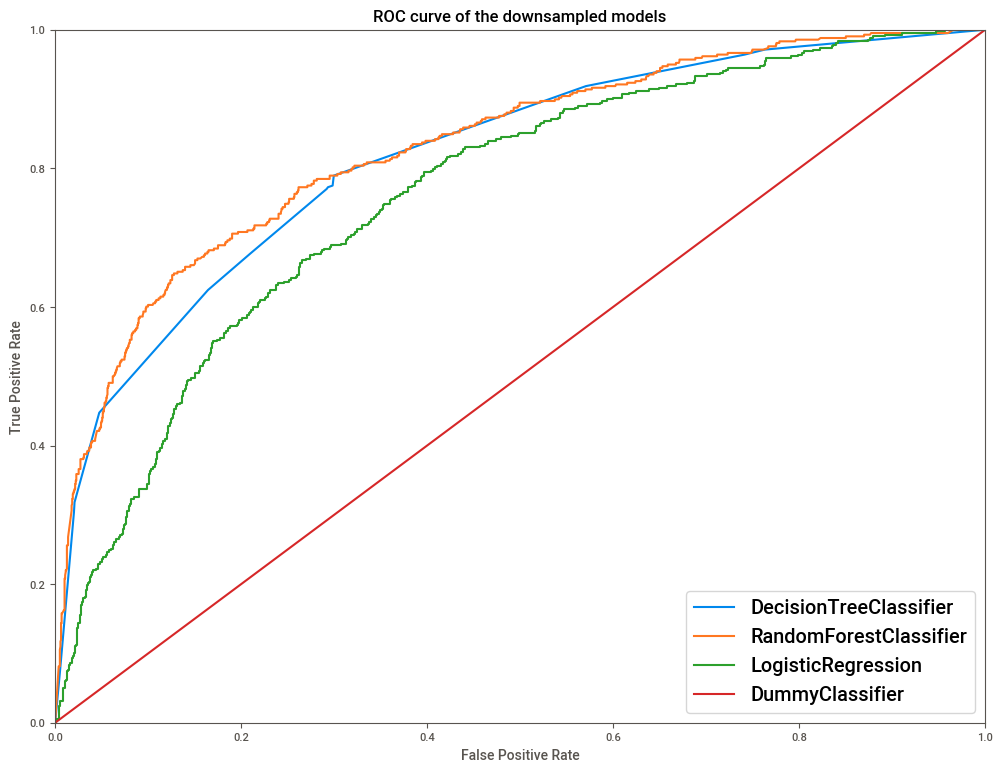

In [37]:
plt.figure(figsize=[12,9])


model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier( random_state=12345, n_estimators=10, max_depth = 10)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression( solver='sag', max_iter = 1000, random_state = 12345)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = DummyClassifier(strategy = 'constant', constant = 1, random_state = 12345)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DummyClassifier',auc_roc)
plt.plot(fpr, tpr, label='DummyClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC curve of the downsampled models")
plt.show()

### Changing the threshold for the LogisticRegression() model

Best threshold = 0.26 | Best f1_score = 0.502 | Best recall = 1.000 | Best precision = 0.702 


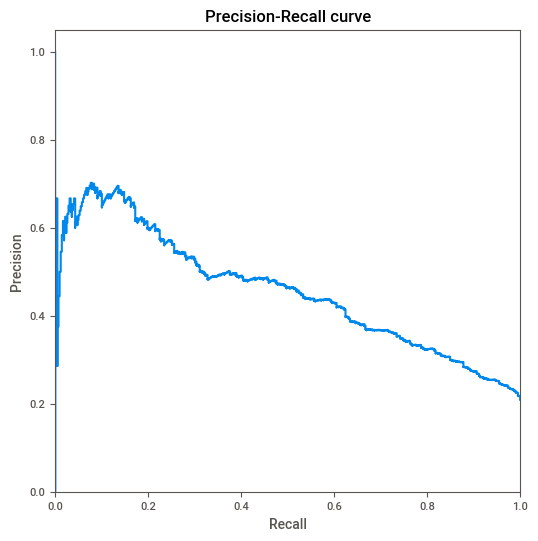

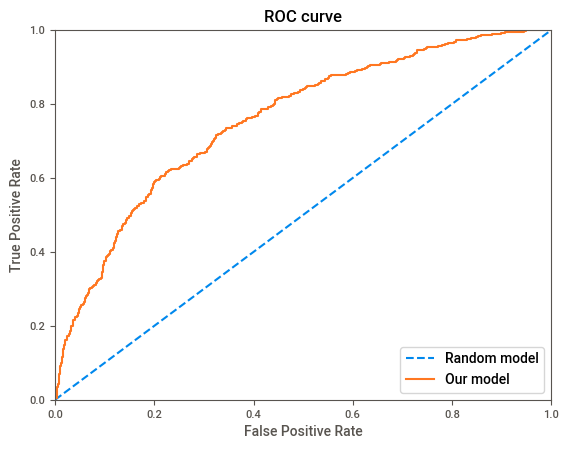

Area Under the Curve: 0.7576836298308118


In [38]:
import warnings
warnings.filterwarnings('ignore')

best_threshold = 0
best_recall = 0
best_precision = 0
best_f1 = 0

model = LogisticRegression(random_state=12345, solver='liblinear', max_iter = 1000)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
    if precision > best_precision:
        best_precision = precision
    if recall > best_recall:
        best_recall = recall
        
print("Best threshold = {:.2f} | Best f1_score = {:.3f} | Best recall = {:.3f} | Best precision = {:.3f} ".format(
       best_threshold, best_f1, best_recall, best_precision))   

#recall-precision curve graph
    
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])


plt.figure(figsize=(6, 6))
plt.step(recall, precision, where = 'post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show() 

# ROC curve graph

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

plt.plot([0, 1], [0, 1], linestyle='--', label='Random model')
plt.plot(fpr,tpr, label = 'Our model')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc= 'lower right')
plt.show()

print('Area Under the Curve:', roc_auc_score(target_valid, probabilities_valid[:, 1] ))

Even after changing the threshold, the accuracy of the model does not increase. The area under the curve is 25% larger than the random model, but this is not enough. The curve goes to the right too early, which means the FP ratio is increasing too quickly relative to TP.

## Model testing

We take the best model and use it to predict the target of the test sample.

In [39]:
model = RandomForestClassifier(class_weight = 'balanced', max_depth = 10, n_estimators = 10, random_state = 12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
f1_score = f1_score(target_test, predictions_test)
print('Test f1_score:', f1_score)
print('test confusion matrix:\n\n',confusion_matrix(target_test, predictions_test))
print('')
print('Precision:', precision_score(target_test, predictions_test))
print('Recall:', recall_score(target_test, predictions_test))

Test f1_score: 0.613303269447576
test confusion matrix:

 [[1385  192]
 [ 151  272]]

Precision: 0.5862068965517241
Recall: 0.6430260047281324


The accuracy is almost the same as in the validation set. We can determine whether a client will leave with a 60% accuracy.

AUC-ROC DecisionTreeClassifier 0.8457915274386085


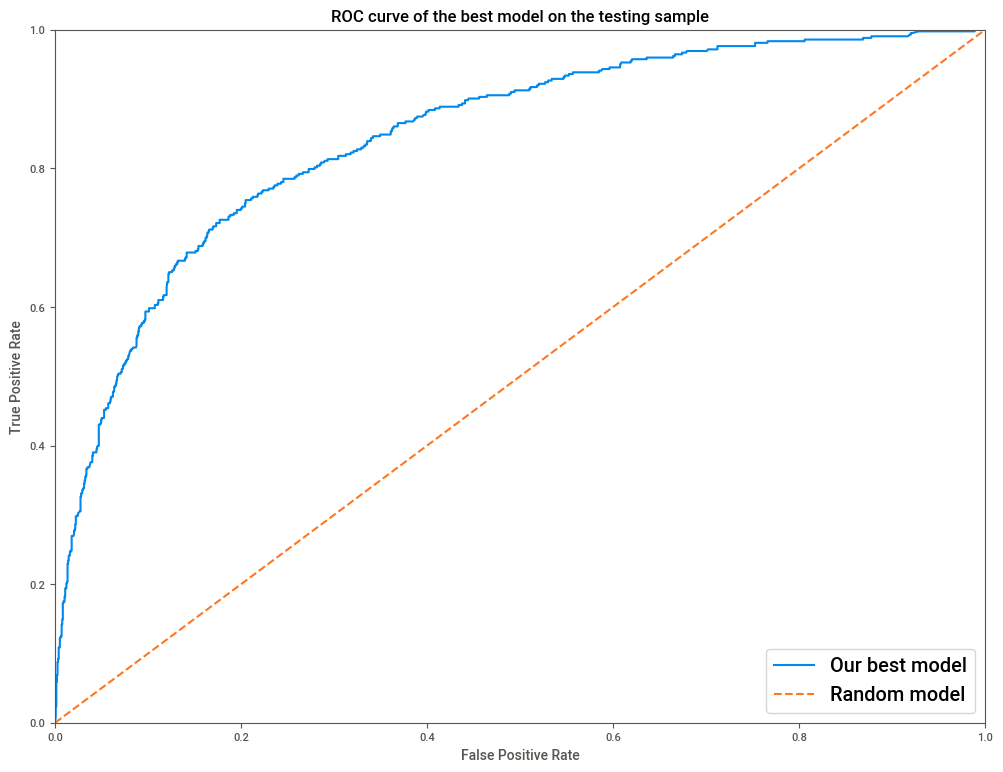

In [40]:
plt.figure(figsize=[12,9])


model = RandomForestClassifier(class_weight = 'balanced', max_depth = 10, n_estimators = 10, random_state = 12345)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='Our best model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random model')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC curve of the best model on the testing sample")
plt.show()

# Conclusion



While working with the project the following was done:

- The data has been studied.
- Scaling has been done.
- The data was divided into training, validation and test samples.
- The problem has been examined. Models without class balance were tested. The best hyperparameters have been established.
- We adjusted the class balance by changing class weights, upsampling, downsampling and changing the threshold.
- An improved model has been developed.
- The final test has been carried out.

The RandomForestClassifier(n_estimators = 10, max_depth = 10, class_weight = 'balanced', random_state = 12345) model turned out to be the most suitable one with an f1_score of 0.6132 and an AUC-ROC of 0.8469.